In [2]:
import pandas as pd   
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings

df_plant_info = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/plant_capacities.csv?raw=true') # replace "small_plant_data" with "large_plant_data" to use the full dataset
# df_plant_info = pd.read_csv('small_plant_data/plant_capacities.csv')
#df_plant_info = df_plant_info.drop(index=[0,1,2,7,5])

P = set(df_plant_info['Plant'].unique()) 
df_load_curves = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/demand.csv?raw=true') 
# df_load_curves = pd.read_csv('demand.csv')

# select the demand for the chosen day (July 1st, 2011)
df_subset = df_load_curves[(df_load_curves['YEAR']==2011)&(df_load_curves['MONTH']==7)&(df_load_curves['DAY']==1)] 
#df_subset['LOAD'] = df_subset['LOAD'] -6000
# store the demand to a dicionary
d = df_subset.set_index(['HOUR']).LOAD.to_dict() 

H = set(d.keys()) # set of hours in a day (1 through 24)

In [120]:
minimum_cap = {}
for i in m.keys():
    minimum_cap[i] = m[i]*c[i]
minimum_cap

{'Jack McDonough': 4.30683,
 'GAS': 17.6130524,
 'Bowen': 26.2237428,
 'OIL': 0.7583748,
 'OTHER COAL': 43.9683212,
 'Vogtle': 1670.9568,
 'HYDRO': 2.6805618,
 'Scherer': 28.601100000000002,
 'Edwin I Hatch': 1301.129824,
 'BIOMASS': 4.7095972}

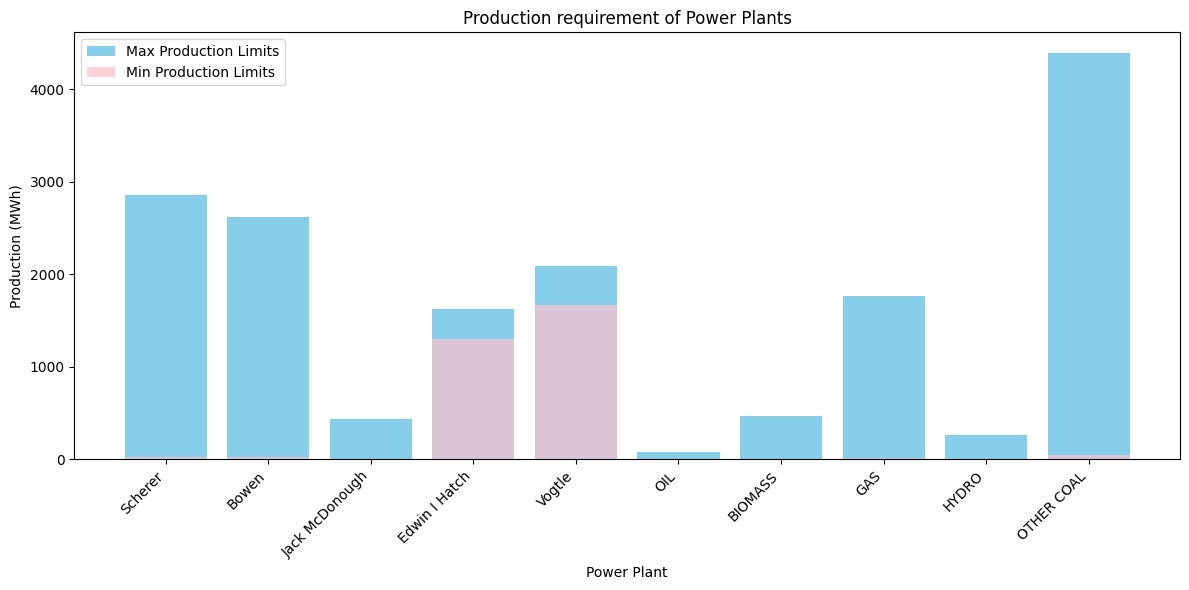

In [131]:
# Data
max_production_limits = {
    'Scherer': 2860.11,
    'Bowen': 2622.37428,
    'Jack McDonough': 430.683,
    'Edwin I Hatch': 1626.41228,
    'Vogtle': 2088.696,
    'OIL': 75.83748,
    'BIOMASS': 470.95972,
    'GAS': 1761.30524,
    'HYDRO': 268.05618,
    'OTHER COAL': 4396.83212
}

min_production_limits = {
    'Jack McDonough': 4.30683,
    'GAS': 17.6130524,
    'Bowen': 26.2237428,
    'OIL': 0.7583748,
    'OTHER COAL': 43.9683212,
    'Vogtle': 1670.9568,
    'HYDRO': 2.6805618,
    'Scherer': 28.601100000000002,
    'Edwin I Hatch': 1301.129824,
    'BIOMASS': 4.7095972
}

# Extract keys and values
names = list(max_production_limits.keys())
max_values = list(max_production_limits.values())
min_values = [min_production_limits[name] for name in names]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(names, max_values, color='skyblue', label='Max Production Limits')
plt.bar(names, min_values, color='pink', label='Min Production Limits', alpha=0.7)

plt.xlabel('Power Plant')
plt.ylabel('Production (MWh)')
#plt.yscale('log')
plt.title('Production requirement of Power Plants')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

In [124]:
production_limits
c

{'Scherer': 2860.11,
 'Bowen': 2622.37428,
 'Jack McDonough': 430.683,
 'Edwin I Hatch': 1626.41228,
 'Vogtle': 2088.696,
 'OIL': 75.83748,
 'BIOMASS': 470.95972,
 'GAS': 1761.30524,
 'HYDRO': 268.05618,
 'OTHER COAL': 4396.83212}

In [125]:
minimum_cap

{'Jack McDonough': 4.30683,
 'GAS': 17.6130524,
 'Bowen': 26.2237428,
 'OIL': 0.7583748,
 'OTHER COAL': 43.9683212,
 'Vogtle': 1670.9568,
 'HYDRO': 2.6805618,
 'Scherer': 28.601100000000002,
 'Edwin I Hatch': 1301.129824,
 'BIOMASS': 4.7095972}

In [3]:

plant_type = df_plant_info.set_index('Plant').PlantType.to_dict() # plant type for each plant

P_N = set([i for i in P if plant_type[i]=='NUCLEAR'])             # set of all nuclear plants  

fuel_type = df_plant_info.set_index('Plant').FuelType.to_dict()   # fuel type for each plant

df_plant_info['capacity'] = df_plant_info['Capacity']
c = df_plant_info.set_index('Plant').capacity.to_dict() # generation capacity  
m = {i: 0.8 if i in P_N else 0.01 for i in P} # min % generation when on 
r = {i: 1 if i in ['BIOMASS','GAS','HYDRO','OIL'] else .2 if i in P_N else .25 for i in P}  # ramp up/down speed (plant) 
df_fuel_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/fuel_costs.csv?raw=true') 

# read the fuel costs and transform it from fuel-type to plant-name
f = {i: df_fuel_costs[df_fuel_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # dictionary of fuel cost for each plant

df_oper_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/operating_costs.csv?raw=true')  
o = {i: df_oper_costs[df_oper_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)

df_startup_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/startup_costs.csv?raw=true')  

s = {i: df_startup_costs[df_startup_costs['year']==2011].T.to_dict()[9][fuel_type[i]] for i in fuel_type} # operating cost/MWh (plant)
 
t = s.copy() # assume that the cost of shuting down = starting up

df_health_costs = pd.read_csv('https://github.com/Gurobi/modeling-examples/blob/master/power_generation/small_plant_data/health_costs.csv?raw=true')  
a = df_health_costs[(df_health_costs['Year']==2007)&(df_health_costs['Day']==1)].set_index(['Plant','Hour']).to_dict()['Cost'] # operating cost/MWh (plant)
a.update({(i,h): 0 for i in P for h in H if i not in ['Bowen','Jack McDonough','Scherer']})  

In [4]:
model.dispose()

NameError: name 'model' is not defined

In [5]:
import gurobipy as gp
from gurobipy import GRB
model1 = gp.Model("powergeneration")

# Define the variables
z = model1.addVars(P,H,name="z", lb=0) # power generated in each plant for each hour 
u = model1.addVars(P,H,name="u", vtype=GRB.BINARY, lb=0) # is the plant on? for each plant and hour
#v = model.addVars(P,H,name="v", vtype=GRB.BINARY) # start up the plant? for each plant and hour
#w = model.addVars(P,H,name="w", vtype=GRB.BINARY) # shut down the plant? for each plant and hour 

# Set the objective function by adding all the costs 
objective = gp.quicksum(f[i]*z[i,h] for i in P for h in H) # fuel cost
objective += gp.quicksum(a[i,h]*z[i,h] for i in P for h in H) # health cost
objective += gp.quicksum(o[i]*u[i,h] for i in P for h in H) # operating cost
#objective += gp.quicksum(s[i]*v[i,h] for i in P for h in H) # startup cost
#objective += gp.quicksum(t[i]*w[i,h] for i in P for h in H) # shutdown cost
model1.setObjective(objective,sense=GRB.MINIMIZE)

# Set the constraint to meet the demand
model1.addConstrs((gp.quicksum(z[i,h] for i in P) >= d[h]) for h in H)  

# Set the constraint to set the minimum and maximum generation limits
model1.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  
model1.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  

# Set the constraint to always keep the nuclear power plants on
model1.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)   

# Set the constraint to ensure that the ramp-up and ramp-down speeds are within limits
#model.addConstrs((z[i,h]-z[i,h-1]  >= -r[i]*c[i]) for i in P for h in H if h>1)  
#model.addConstrs((z[i,h]-z[i,h-1]  <= r[i]*c[i]) for i in P for h in H if h>1)  

# Set the constraint to ensure that if the plant is turned on, the plant should be on
#model.addConstrs((v[i,h] <= u[i,h]) for i in P for h in H)  

# Set the constraint to ensure that if the plant is turned off, the plant should be off
#model.addConstrs((w[i,h] <= 1-u[i,h]) for i in P for h in H)  

# Set the constraint to link the startup/shutdown variables (v,w) to the on/off variables (u)
#model.addConstrs((v[i,h] - w[i,h] == u[i,h] - u[i,h-1]) for i in P for h in H if h > 1) 

# Solve the model
model1.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-15
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 552 rows, 480 columns and 1248 nonzeros
Model fingerprint: 0x84078371
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+03]
  Objective range  [5e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+04]
Found heuristic solution: objective 6097264.0849
Presolve removed 537 rows and 464 columns
Presolve time: 0.03s
Presolved: 15 rows, 16 columns, 44 nonzeros
Found heuristic solution: objective 4540010.6809
Variable types: 8 continuous, 8 integer (8 binary)

Root relaxation: objective 4.494605e+06, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes   

In [146]:
o

{'Scherer': 7.38087979,
 'Bowen': 7.38449513,
 'Jack McDonough': 7.38449513,
 'Edwin I Hatch': 16.31015976,
 'Vogtle': 16.31015976,
 'OIL': 5.29506293,
 'BIOMASS': 5.29506293,
 'GAS': 5.28716388,
 'HYDRO': 8.176099031,
 'OTHER COAL': 7.38449513}

In [139]:
n

NameError: name 'n' is not defined

In [14]:
z_values = [z[i, h].X for i in P for h in H]
u_values = [u[i, h].X for i in P for h in H]
dic = {}
k = 0
for i in P:
    dic[i] = k
    k += 1

In [6]:
def distribute_n_to_a(a, b, n):
    # Convert a and b to numpy arrays for easier manipulation
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    
    # Compute the difference array
    difference = b - a
    
    # Find the total available space in b to accommodate the additional n
    total_difference = np.sum(difference)
    
    # Check if the total available space is enough
    if total_difference < n:
        n = total_difference - 0.1
    
    # Initialize the new_a as a copy of a
    #new_a = a.copy()
    
    # Randomly distribute n among the entries of a
    while n > 0:
        #print(n)
        # Select a random index
        idx = np.random.choice(len(a))
        difference = b - a
        
        # Determine the maximum value we can add to new_a[idx] without violating b[idx] >= new_a[idx]
        max_addition = min(difference[idx], n)
        
        if max_addition > 0:
            # Randomly choose a value to add to new_a[idx] between 0 and max_addition
            addition = np.random.uniform(0, max_addition)
        else:
            addition = 0
        
        # Update new_a and the remaining n
        a[idx] += addition
        n -= addition
    
    return a.tolist()

In [167]:
rows = 10
cols = 24
import random
import numpy as np
def generate_population(kazibi, prob_distri, seed, total_r = 0, total_r1 = False, ratio = 1):
    random.seed(seed)
    np.random.seed(seed)
    initiallaikaka = []
    for prob in prob_distri:
        need = 0
        while need < kazibi/len(prob_distri):
            ui = np.array([np.random.choice([0,1], p=[1-prob,prob]) for j in range(rows * cols)])
            uii = ui.reshape((rows, cols))
            zi = np.zeros((rows, cols))
            for h in range(cols):
                uii[0,h] = 1
                uii[9,h] = 1
                ci = []
                if total_r == 0:
                    for j in P:
                        zi[dic[j], h] = c[j]*uii[dic[j],h] * ratio
                        ci.append(c[j])
                elif total_r == 1:
                    for j in P:
                        zi[dic[j], h] = c[j]*uii[dic[j],h] * ratio * np.random.choice([m[j],1])
                        ci.append(c[j])
                else:
                    for j in P:
                        zi[dic[j], h] = c[j]*np.random.uniform(m[j],1)#*uii[dic[j],h]
                        ci.append(c[j])
                    if total_r1 == True:
                        if np.sum(zi[:,h]) < d[h+1]:
                            laika = np.random.uniform(d[h+1]+1 -np.sum(zi[:,h]), np.sum(np.array(ci)*np.array(uii[:,h])))
                            if np.sum(np.array(ci)*np.array(uii[:,h]) - zi[:, h]) >= d[h+1]+1 -np.sum(zi[:,h]):
                                zi[:, h] = distribute_n_to_a(zi[:, h], np.array(ci)*np.array(uii[:,h]),  laika )
            
            zi = zi.flatten()
            ui = uii.flatten()
            initiali = np.concatenate((zi,ui))
            initiallaikaka.append(initiali)
            need +=1
    return initiallaikaka

In [8]:
gene_space = []
'''# Set the constraint to always keep the nuclear power plants on
model.addConstrs((z[i,h] >= m[i]*c[i]) for i in P_N for h in H)  '''
for h in H:
    for i in P:
        if i in P_N:
            gene_space.append({"low": m[i]*c[i], "high": d[h] - m['Edwin I Hatch']*c['Edwin I Hatch']-m['Vogtle']*c['Vogtle']})
        else:
            gene_space.append({"low": m[i]*c[i], "high":  d[h] -m['Edwin I Hatch']*c['Edwin I Hatch']-m['Vogtle']*c['Vogtle']})


for h in H:
    for i in P:
        if i in P_N:
            gene_space.append([1])
        else:
            gene_space.append([0,1])


new_gene_space = []

for h in H:
    for i in P:
        new_gene_space.append([m[i]*c[i], d[h] - m['Edwin I Hatch']*c['Edwin I Hatch']-m['Vogtle']*c['Vogtle']])


for h in H:
    for i in P:
        if i in P_N:
            new_gene_space.append([1])
        else:
            new_gene_space.append([0,1])

In [9]:
def swap_mutation(offspring, ga_instance, mutation_probability = [0.3, 0.01]):
    """
    Applies the swap mutation which swaps the values of two randomly selected genes. The probability of mutation differs based on the fitness value of the solution.
    It accepts a single parameter:
        - offspring: The offspring to mutate.
    It returns an array of the mutated offspring.
    """

    def swap_genes(individual, idx1, idx2):
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]


    def mutate_gene_value(gene_idx, current_value, gene_space):
        if gene_idx < 240:
            range_min = ga_instance.gene_space[gene_idx]['low']
            range_max = ga_instance.gene_space[gene_idx]['high']
            return np.random.uniform(low=range_min, high=range_max, size=1)[0]
        else:
            return random.choice([0, 1])
        
    def adaptive_mutation_part(part, part_gene_space, average_fitness, offspring_fitness):
        
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]

            probs = np.random.random(size=part.shape[1])
            for gene_idx in range(part.shape[1]):
                if probs[gene_idx] <= adaptive_mutation_probability:
                    current_value = part[offspring_idx, gene_idx]
                    mutated_part[offspring_idx, gene_idx] = mutate_gene_value(gene_idx, current_value, part_gene_space)

                    if not ga_instance.allow_duplicate_genes:
                        mutated_part[offspring_idx], _, _ = ga_instance.solve_duplicate_genes_by_space(
                            solution=mutated_part[offspring_idx], gene_type=ga_instance.gene_type, num_trials=10)

        return mutated_part

    def swap_mutation_part(part, average_fitness, offspring_fitness):
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]

            if np.random.random() <= mutation_prob:
                gene_idx1 = np.random.randint(0, part.shape[1])
                gene_idx2 = np.random.randint(0, part.shape[1])
                while gene_idx1 == gene_idx2:
                    gene_idx2 = np.random.randint(0, part.shape[1])
                swap_genes(mutated_part[offspring_idx], gene_idx1, gene_idx2)

        return mutated_part

    # Split the offspring into z and u
    average_fitness, offspring_fitness = ga_instance.adaptive_mutation_population_fitness(offspring)
    
    z = offspring[:, :240]
    u = offspring[:, 240:]
    
    # Mutate z and u separately
    #z = adaptive_mutation_part(z, gene_space[:240],average_fitness, offspring_fitness)
    #print(z)
    z = swap_mutation_part(z, average_fitness, offspring_fitness)
    u = swap_mutation_part(u, average_fitness, offspring_fitness)
    
    # Check for mutations in u and update z accordingly
    for offspring_idx in range(offspring.shape[0]):
        for i in range(240):
            if offspring[offspring_idx, 240 + i] != u[offspring_idx, i]:  # Check if u[i] has mutated
                if u[offspring_idx, i] == 1:
                    if z[offspring_idx, i] < ga_instance.gene_space[i]['high']:
                        z[offspring_idx, i] = np.random.uniform(
                            low=ga_instance.gene_space[i]['low'], high=ga_instance.gene_space[i]['high'], size=1
                        )[0]
                if u[offspring_idx, i] == 0:
                    z[offspring_idx, i] = 0

    # Concatenate z and u to form the new offspring
    new_offspring = np.concatenate((z, u), axis=1)
    return new_offspring

In [151]:
def swap_mutation_no_Constraint(offspring, ga_instance, mutation_probability = [0.3, 0.01]):
    """
    Applies the swap mutation which swaps the values of two randomly selected genes. The probability of mutation differs based on the fitness value of the solution.
    It accepts a single parameter:
        - offspring: The offspring to mutate.
    It returns an array of the mutated offspring.
    """

    def swap_genes(individual, idx1, idx2):
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]


    def mutate_gene_value(gene_idx, current_value, gene_space):
        if gene_idx < 240:
            range_min = ga_instance.gene_space[gene_idx]['low']
            range_max = ga_instance.gene_space[gene_idx]['high']
            return np.random.uniform(low=range_min, high=range_max, size=1)[0]
        else:
            return random.choice([0, 1])
        
    def adaptive_mutation_part(part, part_gene_space, average_fitness, offspring_fitness):
        
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]

            probs = np.random.random(size=part.shape[1])
            for gene_idx in range(part.shape[1]):
                if probs[gene_idx] <= adaptive_mutation_probability:
                    current_value = part[offspring_idx, gene_idx]
                    mutated_part[offspring_idx, gene_idx] = mutate_gene_value(gene_idx, current_value, part_gene_space)

                    if not ga_instance.allow_duplicate_genes:
                        mutated_part[offspring_idx], _, _ = ga_instance.solve_duplicate_genes_by_space(
                            solution=mutated_part[offspring_idx], gene_type=ga_instance.gene_type, num_trials=10)

        return mutated_part

    def swap_mutation_part(part, average_fitness, offspring_fitness):
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]

            if np.random.random() <= mutation_prob:
                gene_idx1 = np.random.randint(0, part.shape[1])
                gene_idx2 = np.random.randint(0, part.shape[1])
                while gene_idx1 == gene_idx2:
                    gene_idx2 = np.random.randint(0, part.shape[1])
                swap_genes(mutated_part[offspring_idx], gene_idx1, gene_idx2)

        return mutated_part

    # Split the offspring into z and u
    average_fitness, offspring_fitness = ga_instance.adaptive_mutation_population_fitness(offspring)
    
    z = offspring[:, :240]
    u = offspring[:, 240:]
    
    # Mutate z and u separately
    #z = adaptive_mutation_part(z, gene_space[:240],average_fitness, offspring_fitness)
    #print(z)
    z = swap_mutation_part(z, average_fitness, offspring_fitness)
    u = swap_mutation_part(u, average_fitness, offspring_fitness)
    


    # Concatenate z and u to form the new offspring
    new_offspring = np.concatenate((z, u), axis=1)
    return new_offspring

In [87]:
def swap_mutation2(offspring, ga_instance, mutation_probability = [0.3, 0.01], mutation_prob1 = [0.3, 0.01], mutation_prob2 = [0.3, 0.01]):
    """
    Applies the swap mutation which swaps the values of two randomly selected genes. The probability of mutation differs based on the fitness value of the solution.
    It accepts a single parameter:
        - offspring: The offspring to mutate.
    It returns an array of the mutated offspring.
    """

    def swap_genes(individual, idx1, idx2):
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]


    def mutate_gene_value(gene_idx, current_value, gene_space0, choice):
        if choice == 0:
            #print(gene_space0[gene_idx])
            #print(gene_idx)
            range_min = gene_space0[gene_idx][0]
            range_max = gene_space0[gene_idx][1]
            #return np.random.uniform(low=range_min, high=range_max, size=1)[0]
            prob = np.random.uniform(0,1)
            if prob < 0.5:
                return np.random.uniform(low=range_min, high=current_value, size=1)[0]
            else:
                return np.random.uniform(low=current_value, high=range_max, size=1)[0]
        else:
            if len(gene_space0[gene_idx])>1:
                if current_value == 0:
                    return 1
                else:
                    return 0 
            return current_value
        
    def adaptive_mutation_part(part, part_gene_space, average_fitness, offspring_fitness, mutation_prob1, choice):
        
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    adaptive_mutation_probability = mutation_prob1[0]
                else:
                    adaptive_mutation_probability = mutation_prob1[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    adaptive_mutation_probability = mutation_prob1[0]
                else:
                    adaptive_mutation_probability = mutation_prob1[1]

            probs = np.random.random(size=part.shape[1])
            for gene_idx in range(part.shape[1]):
                if probs[gene_idx] <= adaptive_mutation_probability:
                    current_value = part[offspring_idx, gene_idx]
                    mutated_part[offspring_idx, gene_idx] = mutate_gene_value(gene_idx, current_value, part_gene_space, choice)

                    if not ga_instance.allow_duplicate_genes:
                        mutated_part[offspring_idx], _, _ = ga_instance.solve_duplicate_genes_by_space(
                            solution=mutated_part[offspring_idx], gene_type=ga_instance.gene_type, num_trials=10)

        return mutated_part

    def swap_mutation_part(part, average_fitness, offspring_fitness, mutation_probability):
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    mutation_prob = mutation_probability[0]
                else:
                    mutation_prob = mutation_probability[1]

            if np.random.random() <= mutation_prob:
                gene_idx1 = np.random.randint(0, part.shape[1])
                gene_idx2 = np.random.randint(0, part.shape[1])
                while gene_idx1 == gene_idx2:
                    gene_idx2 = np.random.randint(0, part.shape[1])
                swap_genes(mutated_part[offspring_idx], gene_idx1, gene_idx2)

        return mutated_part

    # Split the offspring into z and u
    average_fitness, offspring_fitness = ga_instance.adaptive_mutation_population_fitness(offspring)
    
    z = offspring[:, :rows * cols]
    u = offspring[:, rows * cols:]
    
    # Mutate z and u separately
    z = swap_mutation_part(z, average_fitness, offspring_fitness, mutation_probability)
    z = adaptive_mutation_part(z, new_gene_space[:rows * cols], average_fitness, offspring_fitness, mutation_prob1, 0)
    #print(z)
    
    u = swap_mutation_part(u, average_fitness, offspring_fitness, mutation_probability)
    u = adaptive_mutation_part(u, gene_space[rows * cols:], average_fitness, offspring_fitness, mutation_prob2, 1)
  
    # Check for mutations in u and update z accordingly
    for offspring_idx in range(offspring.shape[0]):
        for i in range(rows * cols):
            if offspring[offspring_idx, rows * cols + i] != u[offspring_idx, i]:  # Check if u[i] has mutated
                if u[offspring_idx, i] == 1:
                    if z[offspring_idx, i] < new_gene_space[i][1]:
                        z[offspring_idx, i] = np.random.uniform(
                            low=new_gene_space[i][0] , high=new_gene_space[i][1], size=1 #+ 1/2*(new_gene_space[i][1]-new_gene_space[i][0])
                        )[0]
            if u[offspring_idx, i] == 0:
                z[offspring_idx, i] = 0
            

    # Concatenate z and u to form the new offspring
    new_offspring = np.concatenate((z, u), axis=1)
    return new_offspring

In [12]:
def adaptive_mutation2(offspring, ga_instance, mutation_probability = [0.03,0.01]):
    """
    Applies the adaptive mutation which changes the values of a number of genes randomly. In adaptive mutation, the number of genes to mutate differs based on the fitness value of the solution.
    The random value is selected either using the provided 'new_gene_space' parameter or the standard mutation logic.
    It accepts a single parameter:
        -offspring: The offspring to mutate.
    It returns an array of the mutated offspring.
    """

    def mutate_gene_value(gene_idx, current_value, gene_space):
        if gene_idx < 240:
            range_min = ga_instance.gene_space[gene_idx]['low']
            range_max = ga_instance.gene_space[gene_idx]['high']
            return np.random.uniform(low=range_min, high=range_max, size=1)[0]
        else:
            return random.choice([0, 1])

    def adaptive_mutation_part(part, part_gene_space, average_fitness, offspring_fitness):
        
        mutated_part = part.copy()

        for offspring_idx in range(part.shape[0]):
            fitness_comparison = offspring_fitness[offspring_idx] < average_fitness

            if type(fitness_comparison) in [bool, np.bool_]:
                if offspring_fitness[offspring_idx] < average_fitness:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]
            else:
                fitness_comparison_sum = sum(fitness_comparison)
                if fitness_comparison_sum >= len(fitness_comparison) / 2:
                    adaptive_mutation_probability = mutation_probability[0]
                else:
                    adaptive_mutation_probability = mutation_probability[1]

            probs = np.random.random(size=part.shape[1])
            for gene_idx in range(part.shape[1]):
                if probs[gene_idx] <= adaptive_mutation_probability:
                    current_value = part[offspring_idx, gene_idx]
                    mutated_part[offspring_idx, gene_idx] = mutate_gene_value(gene_idx, current_value, part_gene_space)

                    if not ga_instance.allow_duplicate_genes:
                        mutated_part[offspring_idx], _, _ = ga_instance.solve_duplicate_genes_by_space(
                            solution=mutated_part[offspring_idx], gene_type=ga_instance.gene_type, num_trials=10)

        return mutated_part

    # Split the offspring into z and u
    average_fitness, offspring_fitness = ga_instance.adaptive_mutation_population_fitness(offspring)
    #new_offspring = adaptive_mutation_part(offspring, ga_instance.gene_space)
    # Mutate z and u separately
    
    z = offspring[:, :240]
    u = offspring[:, 240:]
    z = adaptive_mutation_part(z, gene_space[:240],average_fitness, offspring_fitness)
    u = adaptive_mutation_part(u, gene_space[240:],average_fitness, offspring_fitness)
    zh = z.reshape((rows, cols))
    zh = np.sum(zh, axis=0)
    diff = abs(zh - list(d.values()))
    # Check for mutations in u and update z accordingly
    for offspring_idx in range(offspring.shape[0]):
        for i in range(240):
            if offspring[offspring_idx, 240 + i] != u[offspring_idx, i]:  # Check if u[i] has mutated
                if u[offspring_idx, i] == 1:
                    if z[offspring_idx, i] < new_gene_space[i][1]:
                        z[offspring_idx, i] = min(new_gene_space[i][0], diff[i%24])
                        z[offspring_idx, i] = np.random.uniform(
                            low=new_gene_space[i][1], high=new_gene_space[i][0], size=1
                        )[0]
            if u[offspring_idx, i] == 0:
                z[offspring_idx, i] = 0

    # Concatenate z and u to form the new offspring
    new_offspring = np.concatenate((z, u), axis=1)
    return new_offspring

In [15]:
import numpy as np
import random

def crossover(parents, offspring_size, ga_instance):
    def uniform_crossover(parents, offspring_size, ga_instance):

        """
        Applies the uniform crossover. For each gene, a parent out of the 2 mating parents is selected randomly and the gene is copied from it.
        It accepts 2 parameters:
            -parents: The parents to mate for producing the offspring.
            -offspring_size: The size of the offspring to produce.
        It returns an array the produced offspring.
        """

        if ga_instance.gene_type_single:
            offspring = np.empty(offspring_size, dtype=ga_instance.gene_type[0])
        else:
            offspring = np.empty(offspring_size, dtype=object)

        # Generate the mask for the last 240 genes
        mask = np.random.randint(low=0, high=2, size=240)

        for k in range(offspring_size[0]):
            if ga_instance.crossover_probability is not None:
                probs = np.random.random(size=parents.shape[0])
                indices = list(set(np.where(probs <= ga_instance.crossover_probability)[0]))

                # If no parent satisfied the probability, no crossover is applied and a parent is selected.
                if len(indices) == 0:
                    offspring[k, :] = parents[k % parents.shape[0], :]
                    continue
                elif len(indices) == 1:
                    parent1_idx = indices[0]
                    parent2_idx = parent1_idx
                else:
                    indices = random.sample(indices, 2)
                    parent1_idx = indices[0]
                    parent2_idx = indices[1]
            else:
                # Index of the first parent to mate.
                parent1_idx = k % parents.shape[0]
                # Index of the second parent to mate.
                parent2_idx = (k+1) % parents.shape[0]

            # Perform crossover for the first 240 genes
            for gene_idx in range(240):
                if mask[gene_idx] == 0:
                    offspring[k, gene_idx] = parents[parent1_idx, gene_idx]
                else:
                    offspring[k, gene_idx] = parents[parent2_idx, gene_idx]

            # Perform crossover for the last 240 genes
            for gene_idx in range(240, 480):
                if mask[gene_idx - 240] == 0:
                    offspring[k, gene_idx] = parents[parent1_idx, gene_idx]
                else:
                    offspring[k, gene_idx] = parents[parent2_idx, gene_idx]

            if not ga_instance.allow_duplicate_genes:
                if ga_instance.gene_space is None:
                    offspring[k], _, _ = ga_instance.solve_duplicate_genes_randomly(
                        solution=offspring[k],
                        min_val=ga_instance.random_mutation_min_val,
                        max_val=ga_instance.random_mutation_max_val,
                        mutation_by_replacement=ga_instance.mutation_by_replacement,
                        gene_type=ga_instance.gene_type,
                        num_trials=10
                    )
                else:
                    offspring[k], _, _ = ga_instance.solve_duplicate_genes_by_space(
                        solution=offspring[k],
                        gene_type=ga_instance.gene_type,
                        num_trials=10
                    )

        return offspring

    offspring = uniform_crossover(parents, offspring_size, ga_instance)
    return offspring


In [111]:
def fitness_func(ga_instance, solution, solution_idx):
    z = solution[0:rows * cols]
    u = solution[rows * cols:]

    z = z.reshape((rows, cols))
    u = u.reshape((rows, cols))

   

    output1 = 0
    output2 = 0
    output3 = 0

    for h in range(0,cols):
        for i in P:
            output1 += f[i]*z[dic[i],h]
            #print(a[i,h+1])
            output2 += a[i,h+1]*z[dic[i],h]
            output3 += o[i]*u[dic[i],h] 

    output = 1/(output1+output2+output3)

    for h in range(0,cols):
        zh = 0
        if u[0, h] != 1 or u[9, h] != 1:
            output -= 100000
        for i in P:
            zh += z[dic[i],h]
            '''model.addConstrs((z[i,h] >= m[i]*c[i]*u[i,h]) for i in P for h in H)  
               model.addConstrs((z[i,h] <= c[i]*u[i,h]) for i in P for h in H)  '''
            if abs(z[dic[i],h] - c[i]*u[dic[i],h])>0.1:
                if z[dic[i],h] < m[i]*c[i]*u[dic[i],h] :
                    #return -10000
                    output+= (z[dic[i],h]- m[i]*c[i]*u[dic[i],h])
                    #print(1)
                if z[dic[i],h] > c[i]*u[dic[i],h]+0.1:
                    output+= (c[i]*u[dic[i],h] - z[dic[i],h])
                    #print(2)
                    #return -10000
                '''
        # Set the constraint to meet the demand
        model.addConstrs((gp.quicksum(z[i,h] for i in P) >= d[h]) for h in H)  
        '''
        #if  abs(zh - d[h+1])>100:
        
        if zh < 0.99*d[h+1]:
            output+= -abs(d[h+1]-zh)
        #if  abs(zh - d[h+1])>0.3*d[h+1]:
            #output+= -abs(d[h+1]-zh)
            #print(3)
            #return -10000
    #if output>0:
    #print(output)
    return output

In [260]:
num_genes = rows * cols * 2
mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.4,0.1], 2*np.array([0.005,0.001]), [0.005,0.001])
mutation_wrapper2 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.25,0.25])
mutation_wrapper3 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.4,0.1])
dynamic_wrapper1 = lambda offspring, ga_instance: dynamic_mutation(offspring, ga_instance, 0.005e-07)
def dynamic_mutation(offspring, ga_instance, threshold = 0.001e-07):
    if ga_instance.generations_completed > 300:
        if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-60] < threshold:#0.00025
            return mutation_wrapper1(offspring, ga_instance)
    return mutation_wrapper3(offspring, ga_instance)


In [72]:
import pygad

import matplotlib.pyplot as plt

def plot_differences(data):
    # Calculate the differences between consecutive values
    differences = [j - i for i, j in zip(data[:-1], data[1:])]
    
    # Create a plot
    plt.figure(figsize=(10, 6))
    
    # Plot the differences
    plt.plot(differences, marker='o', linestyle='-', color='b')
    
    # Adding title and labels
    plt.title('Differences Between Consecutive Values')
    plt.xlabel('Index')
    plt.ylabel('Difference')
    
    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [80]:
# Callback function to print generation number
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
    if ga_instance.generations_completed > 300: 
        if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-60] < 0.001e-07:
            print("laika")
        else:
            print("zibi")
    #if ga_instance.generations_completed%50 == 0:
        #modify_worst_population(ga_instance)
        #if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-200] < 0.0005e-07:#0.00025
            #print("laikasigo")
        #if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-50] < 0.001e-07:#0.00025
            #modify_worst_population(ga_instance)
            #print("kazi")
            #ga_instance.mutation_type=mutation_wrapper3
        #elif ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-30] < 0.001e-07:
            #print("laika")
            #ga_instance.mutation_type=mutation_wrapper4
        #else:
            #print("zibi")
            #ga_instance.crossover_type = "uniform"
            #ga_instance.mutation_type=mutation_wrapper2
    #if ga_instance.best_solutions_fitness[-1] > 1.75e-07:
        #ga_instance.keep_elitism=1
        #ga_instance.mutation_type=mutation_wrapper2

In [321]:


initial = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8)
ga_instance = pygad.GA(num_generations=20000,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_mutation ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initial ,
                       on_generation=on_generation,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instance.run()

Generation: 1
1.0386489080589178e-07
Generation: 2
1.0386489080589178e-07
Generation: 3
1.0386489080589178e-07
Generation: 4
1.0386489080589178e-07
Generation: 5
1.0386489080589178e-07
Generation: 6
1.0386489080589178e-07
Generation: 7
1.0460010552197722e-07
Generation: 8
1.0460010552197722e-07
Generation: 9
1.0460010552197722e-07
Generation: 10
1.0460010552197722e-07
Generation: 11
1.0460010552197722e-07
Generation: 12
1.0460010552197722e-07
Generation: 13
1.0473606955452556e-07
Generation: 14
1.0473606955452556e-07
Generation: 15
1.0482420182343626e-07
Generation: 16
1.0493764927268949e-07
Generation: 17
1.0493764927268949e-07
Generation: 18
1.0512889330144554e-07
Generation: 19
1.0570461842859824e-07
Generation: 20
1.0570461842859824e-07
Generation: 21
1.0570461842859824e-07
Generation: 22
1.0570461842859824e-07
Generation: 23
1.0570461842859824e-07
Generation: 24
1.0570907086345157e-07
Generation: 25
1.0570907086345157e-07
Generation: 26
1.0607408134738821e-07
Generation: 27
1.0694

NameError: name 'ga_instance' is not defined

Generation: 1
1.0386489080589178e-07
Generation: 2
1.0386489080589178e-07
Generation: 3
1.0386489080589178e-07
Generation: 4
1.0386489080589178e-07
Generation: 5
1.0386489080589178e-07
Generation: 6
1.0386489080589178e-07
Generation: 7
1.0460010552197722e-07
Generation: 8
1.0460010552197722e-07
Generation: 9
1.0460010552197722e-07
Generation: 10
1.0460010552197722e-07
Generation: 11
1.0460010552197722e-07
Generation: 12
1.0460010552197722e-07
Generation: 13
1.0473606955452556e-07
Generation: 14
1.0473606955452556e-07
Generation: 15
1.0482420182343626e-07
Generation: 16
1.0493764927268949e-07
Generation: 17
1.0493764927268949e-07
Generation: 18
1.0512889330144554e-07
Generation: 19
1.0570461842859824e-07
Generation: 20
1.0570461842859824e-07
Generation: 21
1.0570461842859824e-07
Generation: 22
1.0570461842859824e-07
Generation: 23
1.0570461842859824e-07
Generation: 24
1.0570907086345157e-07
Generation: 25
1.0570907086345157e-07
Generation: 26
1.0607408134738821e-07
Generation: 27
1.0694

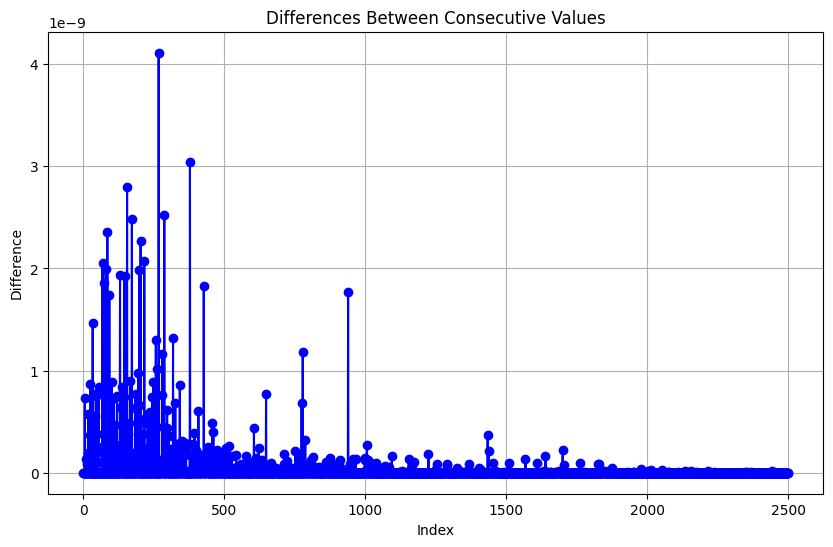

In [301]:
initial = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8)
def modify_worst_population(ga_instance):
    # Get the fitness of the population
    fitness = ga_instance.last_generation_fitness
    
    # Sort the population based on fitness (ascending order)
    sorted_indices = np.argsort(fitness)
    
    # Determine the number of individuals to modify
    num_individuals_to_modify = int(len(fitness) /2) 
    
    gou = generate_population(num_individuals_to_modify, [ 0.65, 0.55, 0.75], ga_instance.generations_completed )
    #print(gou[0])
    new_individuals = gou[:num_individuals_to_modify]
    
    # Replace the worst individuals with the new ones
    for i in range(num_individuals_to_modify):
        ga_instance.population[sorted_indices[i]] = new_individuals[i]
        # Update the fitness of the modified individuals
        ga_instance.last_generation_fitness[sorted_indices[i]] = fitness_func(ga_instance, new_individuals[i], sorted_indices[i])



    
    
    #print(max(ga_instance.last_generation_fitness))
    #if ga_instance.generations_completed>10:
        #print(ga_instance.best_solutions_fitness[-10])
mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], np.array([0.005,0.001]), [0.005,0.001])
num_generations = 500


ga_instance1 = pygad.GA(num_generations=2500,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_mutation ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initial ,
                       on_generation=on_generation,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instance1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution1, solution_fitness1, solution_idx1 = ga_instance1.best_solution(ga_instance1.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness1}")
plot_differences(ga_instance1.best_solutions_fitness)

In [99]:
initial = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8)
mutation_wrapper3 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.4,0.1])
ga_instance1_swap = pygad.GA(num_generations=2500,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population=initial,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper3,
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1_swap.population#ga_instance1.population
                       )

ga_instance1_swap.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution1_swap, solution_fitness1_swap, solution_idx1_swap = ga_instance1_swap.best_solution(ga_instance1_swap.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness1_swap}")
plot_differences(ga_instance1_swap.best_solutions_fitness)

Generation: 1
1.0659534278773935e-07
Generation: 2
1.0659534278773935e-07
Generation: 3
1.0659534278773935e-07
Generation: 4
1.0659534278773935e-07
Generation: 5
1.0659534278773935e-07
Generation: 6
1.0659534278773935e-07
Generation: 7
1.0659534278773935e-07
Generation: 8
1.0659534278773935e-07
Generation: 9
1.0777590824644726e-07
Generation: 10
1.0777590824644726e-07
Generation: 11
1.0777590824644726e-07
Generation: 12
1.0777590824644726e-07
Generation: 13
1.0777590824644726e-07
Generation: 14
1.081214419497256e-07
Generation: 15
1.081214419497256e-07
Generation: 16
1.081214419497256e-07
Generation: 17
1.081214419497256e-07
Generation: 18
1.081214419497256e-07
Generation: 19
1.081214419497256e-07
Generation: 20
1.0913330672597774e-07
Generation: 21
1.0913330672597774e-07
Generation: 22
1.0913330672597774e-07
Generation: 23
1.0920490856728478e-07
Generation: 24
1.0920490856728478e-07
Generation: 25
1.0920490856728478e-07
Generation: 26
1.0920490856728478e-07
Generation: 27
1.0976668297

KeyboardInterrupt: 

Generation: 1
1.0386489080589178e-07
Generation: 2
1.0386489080589178e-07
Generation: 3
1.0386489080589178e-07
Generation: 4
1.0386489080589178e-07
Generation: 5
1.0386489080589178e-07
Generation: 6
1.0386489080589178e-07
Generation: 7
1.0386489080589178e-07
Generation: 8
1.0386489080589178e-07
Generation: 9
1.0386489080589178e-07
Generation: 10
1.0386489080589178e-07
Generation: 11
1.0386489080589178e-07
Generation: 12
1.0386489080589178e-07
Generation: 13
1.0488259854818082e-07
Generation: 14
1.0488259854818082e-07
Generation: 15
1.0488259854818082e-07
Generation: 16
1.0488259854818082e-07
Generation: 17
1.0491512117462885e-07
Generation: 18
1.0544298165380995e-07
Generation: 19
1.0664971255760079e-07
Generation: 20
1.0664971255760079e-07
Generation: 21
1.0664971255760079e-07
Generation: 22
1.0664971255760079e-07
Generation: 23
1.0717040868896768e-07
Generation: 24
1.0717040868896768e-07
Generation: 25
1.0717040868896768e-07
Generation: 26
1.0742294198402548e-07
Generation: 27
1.0742

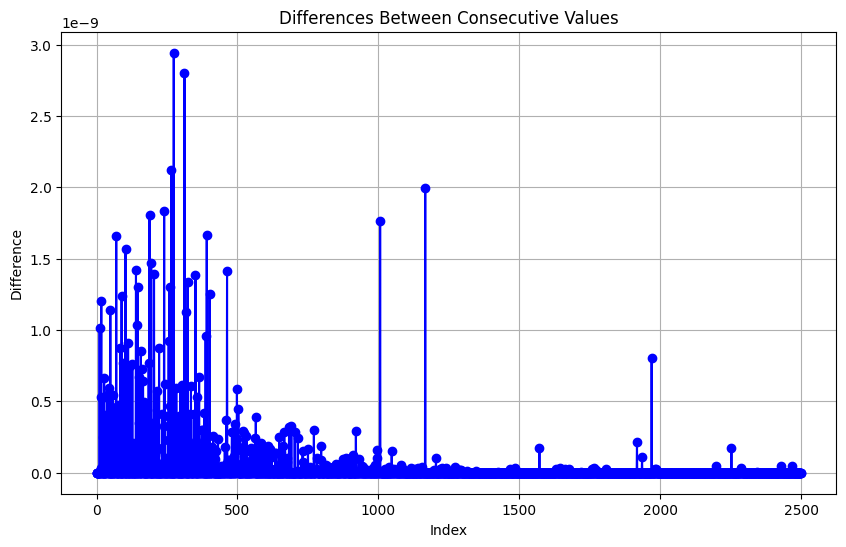

In [309]:
initial = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8)

ga_instance1_constant_swap = pygad.GA(num_generations=2500,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population=initial,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2,
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1_swap.population#ga_instance1.population
                       )

ga_instance1_constant_swap.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution1_constant_swap, solution_fitness1_constant_swap, solution_idx1_constant_swap = ga_instance1_constant_swap.best_solution(ga_instance1_constant_swap.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness1_constant_swap}")
plot_differences(ga_instance1_constant_swap.best_solutions_fitness)

Generation: 1
1.0386489080589178e-07
Generation: 2
1.0386489080589178e-07
Generation: 3
1.0386489080589178e-07
Generation: 4
1.0386489080589178e-07
Generation: 5
1.0386489080589178e-07
Generation: 6
1.0386489080589178e-07
Generation: 7
1.0386489080589178e-07
Generation: 8
1.0386489080589178e-07
Generation: 9
1.0386489080589178e-07
Generation: 10
1.0386489080589178e-07
Generation: 11
1.0386489080589178e-07
Generation: 12
1.0386489080589178e-07
Generation: 13
1.0386489080589178e-07
Generation: 14
1.0386489080589178e-07
Generation: 15
1.0386489080589178e-07
Generation: 16
1.0386489080589178e-07
Generation: 17
1.0386489080589178e-07
Generation: 18
1.0386489080589178e-07
Generation: 19
1.0386489080589178e-07
Generation: 20
1.0386489080589178e-07
Generation: 21
1.0386489080589178e-07
Generation: 22
1.0386489080589178e-07
Generation: 23
1.0386489080589178e-07
Generation: 24
1.0386489080589178e-07
Generation: 25
1.0386489080589178e-07
Generation: 26
1.0386489080589178e-07
Generation: 27
1.0386

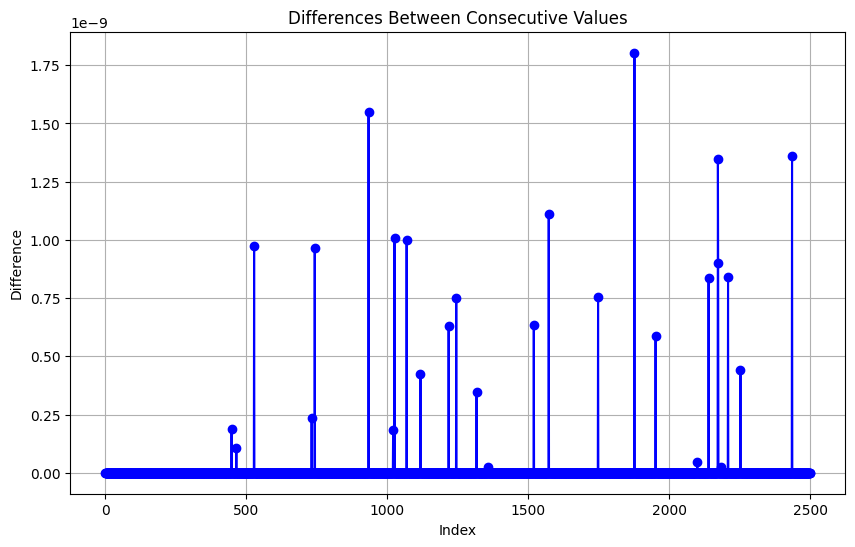

In [256]:
ga_instance1_adaptive = pygad.GA(num_generations=2500,
                       num_parents_mating=400,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       mutation_probability = [0.25,0.01],
                       keep_elitism=5,
                       initial_population=initial,
                       on_generation=on_generation,
                       mutation_type = 'adaptive',
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       )

ga_instance1_adaptive.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution1_adaptive, solution_fitness1_adaptive, solution_idx1_adaptive = ga_instance1_adaptive.best_solution(ga_instance1_adaptive.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness1_adaptive}")
plot_differences(ga_instance1_adaptive.best_solutions_fitness)

NameError: name 'ga_instance1_swap' is not defined

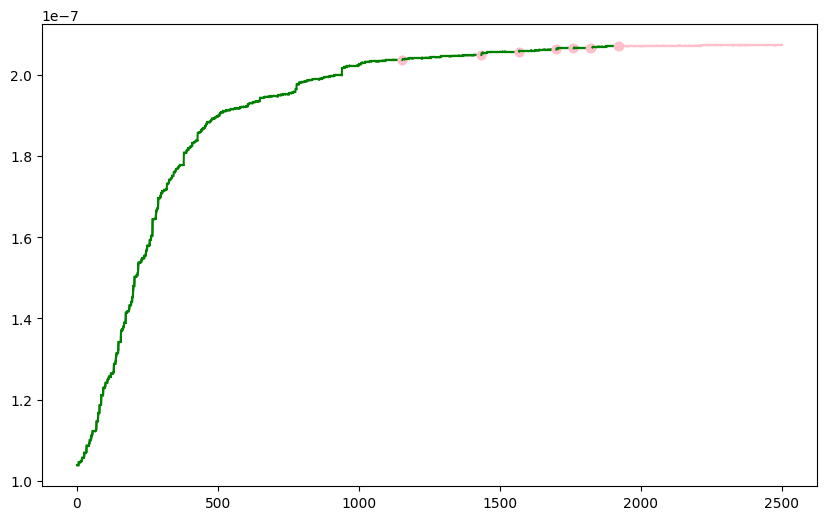

In [98]:
import matplotlib.pyplot as plt

# Read the data from the text file
file_path = 'output0_1.txt'  # Replace with your actual file path
with open(file_path, 'r') as file:
    lines = file.readlines()

generations = []
fitness_values = []
point_types = []

with open(file_path, 'r') as file:
    lines = file.readlines()
    
    # Process the first 600 lines
    for i in range(0, 600, 2):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append("zibi")
    
    # Process lines after 600
    for i in range(600, len(lines), 3):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        point_type = lines[i + 2].strip()
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append(point_type)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the initial segment
plt.plot(generations[:600//2], fitness_values[:600//2], linestyle='-', color='green', label='Dynamic')

# Plot segments with special handling for "laika"
laika_label_added = False

for i in range(1, len(generations)):
    if point_types[i] == "zibi":
        plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='green')
    elif point_types[i] == "laika":
        if point_types[i-1] == "zibi":
            if not laika_label_added:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6, label='Adaptive Random + Adaptive Swap Mutation')
                laika_label_added = True
            else:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6)
        else:
            plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink')

plt.plot(ga_instance1_swap.best_solutions_fitness, linestyle='-', color='r', label='Adaptive Swap Mutation')
plt.plot(ga_instance1_adaptive.best_solutions_fitness, linestyle='-', color='y', label='Adaptive Mutation')
plt.plot(ga_instance1_constant_swap.best_solutions_fitness, linestyle='-', color='b', label='Constant Swap Mutation')
# Adding labels and title
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [97]:
generations = []
fitness_values = []
point_types = []

with open(file_path, 'r') as file:
    lines = file.readlines()
    
    # Process the first 600 lines
    for i in range(0, 600, 2):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append("zibi")
    
    # Process lines after 600
    for i in range(600, len(lines), 3):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        point_type = lines[i + 2].strip()
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append(point_type)

# Filter data to start from generation 1000
start_index = next(i for i, gen in enumerate(generations) if gen >= 1000)
generations = generations[start_index:]
fitness_values = fitness_values[start_index:]
point_types = point_types[start_index:]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot segments with special handling for "laika"
laika_label_added = False

for i in range(1, len(generations)):
    if point_types[i] == "zibi":
        plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='green',label='Adaptive Swap Mutation')
    elif point_types[i] == "laika":
        if point_types[i-1] == "zibi":
            if not laika_label_added:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6, label='Adaptive Random + Adaptive Swap Mutation')
                laika_label_added = True
            else:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6)
        else:
            plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink')

offset = 1000
ga_instance1_best_solutions_fitness = ga_instance1.best_solutions_fitness
plt.plot(range(offset, offset + len(ga_instance1_best_solutions_fitness[offset:])), ga_instance1_swap.best_solutions_fitness[1000:], linestyle='-', color='r', label='Adaptive Swap Mutation')
plt.plot(range(offset, offset + len(ga_instance1_best_solutions_fitness[offset:])), ga_instance1_constant_swap.best_solutions_fitness[1000:], linestyle='-', color='b', label='Constant Swap Mutation')
# Adding labels and title
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations (Starting from Generation 1000)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'file_path' is not defined

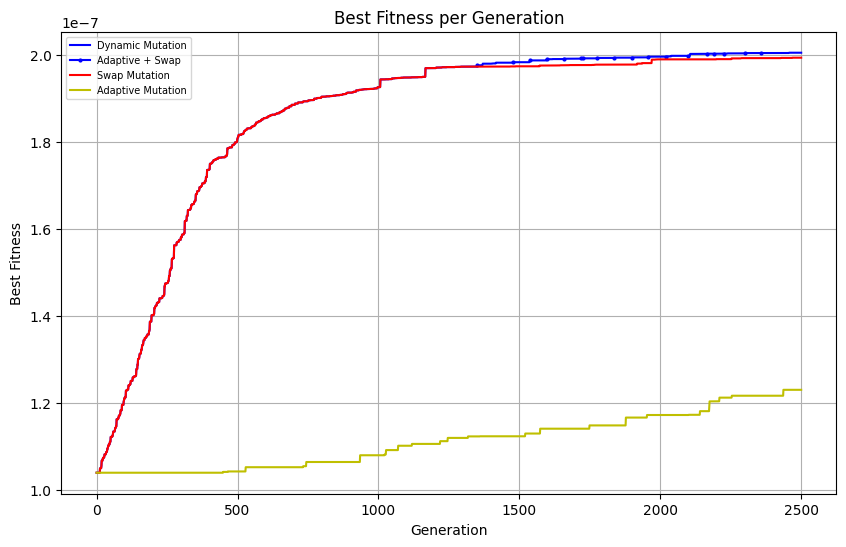

In [275]:
highlight_indexes = [1351, 1477, 1537, 1597, 1657, 1717, 1725, 1777, 1837, 1898, 1958, 2019, 2099, 2166, 2189, 2227, 2299, 2359]
ga_instance1_best_solutions_fitness = ga_instance1.best_solutions_fitness
plt.figure(figsize=(10, 6))
plt.plot(ga_instance1.best_solutions_fitness, linestyle='-', color='b', label='Dynamic Mutation')
for idx in highlight_indexes:
    if idx < len(ga_instance1_best_solutions_fitness):
        plt.plot(idx, ga_instance1_best_solutions_fitness[idx], marker='o', markersize=2, color='b', label='Adaptive + Swap' if idx == highlight_indexes[0] else "")
plt.plot(ga_instance1_swap.best_solutions_fitness, linestyle='-', color='r', label='Swap Mutation')
plt.plot(ga_instance1_adaptive.best_solutions_fitness, linestyle='-', color='y', label='Adaptive Mutation')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')
plt.legend(fontsize=7) 
plt.grid(True)

# Show the plot
plt.show()

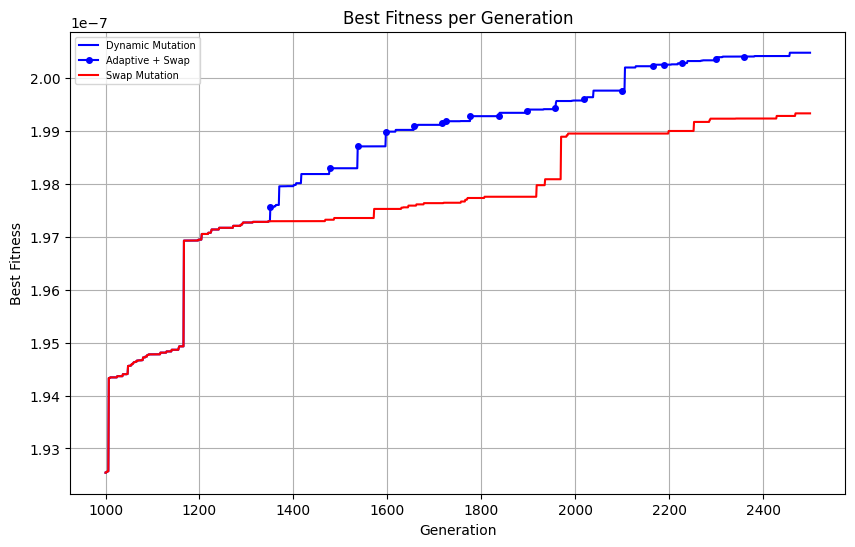

In [276]:
highlight_indexes = np.array([1351, 1477, 1537, 1597, 1657, 1717, 1725, 1777, 1837, 1898, 1958, 2019, 2099, 2166, 2189, 2227, 2299, 2359]) 
offset = 1000
ga_instance1_best_solutions_fitness = ga_instance1.best_solutions_fitness
plt.figure(figsize=(10, 6))
plt.plot(range(offset, offset + len(ga_instance1_best_solutions_fitness[offset:])), ga_instance1_best_solutions_fitness[offset:], linestyle='-', color='b', label='Dynamic Mutation')
for idx in highlight_indexes:
    if idx < len(ga_instance1_best_solutions_fitness) + offset:
        plt.plot(idx, ga_instance1_best_solutions_fitness[idx], marker='o', markersize=4, color='b', label='Adaptive + Swap' if idx == highlight_indexes[0] else "")
plt.plot(range(offset, offset + len(ga_instance1_best_solutions_fitness[offset:])),ga_instance1_swap.best_solutions_fitness[offset:], linestyle='-', color='r', label='Swap Mutation')
#plt.plot(ga_instance1_adaptive.best_solutions_fitness, linestyle='-', color='y', label='Adaptive Mutation')

plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')
plt.legend(fontsize=7) 
plt.grid(True)

# Show the plot
plt.show()

In [285]:
initiallaika = generate_population(1000, [0.45, 0.55, 0.65, 0.75,0.85, 0.95], seed=8, total_r=True)

1.0985574943339419e-07

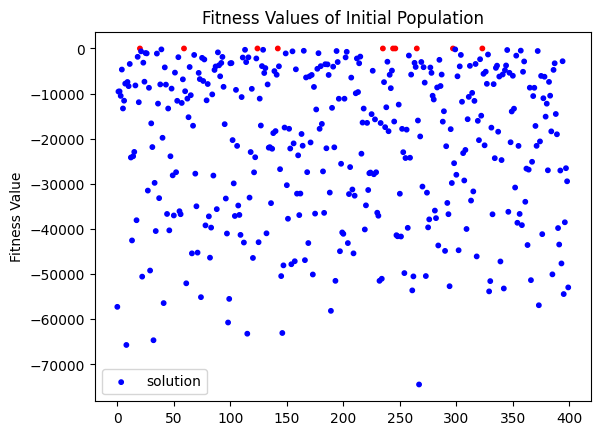

10

In [29]:
initial = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8)
fit = []
inConstraint = 0
for i in initial:
    if fitness_func(0,i,0) >0:
        inConstraint +=1
    fit.append(fitness_func(0,i,0))
    

random.shuffle(fit)

# Determine colors based on fitness values
colors = ['red' if value > 0 else 'blue' for value in fit]

# Create scatter plot with smaller points and conditional coloring
plt.scatter(range(len(fit)), fit, color=colors, marker='o', label='solution', s=10)  # s=20 makes the points smaller

# Add a horizontal line at y=0
#plt.axhline(y=0, color='r', linestyle='--', label='y=0')

# Adding labels and title

plt.ylabel('Fitness Value')
plt.title('Fitness Values of Initial Population')

# Add legend
plt.legend()

# Display the plot
plt.show()
inConstraint

In [233]:
initial = generate_population(400, [ 0.55, 0.65, 0.75,0.85], seed=7)
def modify_worst_population(ga_instance):
    # Get the fitness of the population
    fitness = ga_instance.last_generation_fitness
    
    # Sort the population based on fitness (ascending order)
    sorted_indices = np.argsort(fitness)
    
    # Determine the number of individuals to modify
    num_individuals_to_modify = int(len(fitness) /2) 
    
    gou = generate_population(num_individuals_to_modify, [ 0.65, 0.55, 0.75], ga_instance.generations_completed )
    #print(gou[0])
    new_individuals = gou[:num_individuals_to_modify]
    
    # Replace the worst individuals with the new ones
    for i in range(num_individuals_to_modify):
        ga_instance.population[sorted_indices[i]] = new_individuals[i]
        # Update the fitness of the modified individuals
        ga_instance.last_generation_fitness[sorted_indices[i]] = fitness_func(ga_instance, new_individuals[i], sorted_indices[i])


# Callback function to print generation number
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
    #if ga_instance.generations_completed%50 == 0:
        #modify_worst_population(ga_instance)
        #if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-200] < 0.0005e-07:#0.00025
            #print("laikasigo")
        #if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-50] < 0.001e-07:#0.00025
            #modify_worst_population(ga_instance)
            #print("kazi")
            #ga_instance.mutation_type=mutation_wrapper3
        #elif ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-30] < 0.001e-07:
            #print("laika")
            #ga_instance.mutation_type=mutation_wrapper4
        #else:
            #print("zibi")
            #ga_instance.crossover_type = "uniform"
            #ga_instance.mutation_type=mutation_wrapper2
    #if ga_instance.best_solutions_fitness[-1] > 1.75e-07:
        #ga_instance.keep_elitism=1
        #ga_instance.mutation_type=mutation_wrapper2
    
    
    #print(max(ga_instance.last_generation_fitness))
    #if ga_instance.generations_completed>10:
        #print(ga_instance.best_solutions_fitness[-10])
mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0,0])
num_generations = 500
num_genes = rows * cols * 2

ga_instance1 = pygad.GA(num_generations=1000,
                       num_parents_mating=400,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=10,
                       #initial_population=initial,
                       on_generation=on_generation,
                       initial_population=ga_instance1.population,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       )

ga_instance1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution1, solution_fitness1, solution_idx1 = ga_instance1.best_solution(ga_instance1.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness1}")
plot_differences(ga_instance1.best_solutions_fitness)

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
1.7666627354608403e-07
Generation: 2
1.7666627354608403e-07
Generation: 3
1.7666627354608403e-07
Generation: 4
1.7666627354608403e-07
Generation: 5
1.766770687408284e-07
Generation: 6
1.766770687408284e-07
Generation: 7
1.766770687408284e-07
Generation: 8
1.766770687408284e-07
Generation: 9
1.767207463837555e-07
Generation: 10
1.767207463837555e-07
Generation: 11
1.767207463837555e-07
Generation: 12
1.767207463837555e-07
Generation: 13
1.767207463837555e-07
Generation: 14
1.767207463837555e-07
Generation: 15
1.767207463837555e-07
Generation: 16
1.767207463837555e-07
Generation: 17
1.767207463837555e-07
Generation: 18
1.767207463837555e-07
Generation: 19
1.767207463837555e-07
Generation: 20
1.767207463837555e-07
Generation: 21
1.767207463837555e-07
Generation: 22
1.7674805215065581e-07
Generation: 23
1.7674805215065581e-07
Generation: 24
1.7674805215065581e-07
Generation: 25
1.7680649037070866e-07
Generation: 26
1.7680649037070866e-07
Generation: 27
1.7683382264331837e-07


KeyboardInterrupt: 

In [148]:

initial1 = generate_population(300, [0.45, 0.55,0.65], seed=5)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])

num_genes = rows * cols * 2
mutation_wrapper2 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial1,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain, solution_fitness_plain, solution_idx_plain = ga_instance_plain.best_solution(ga_instance_plain.last_generation_fitness)
saved_solutions = ga_instance_plain.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain}")
#plot_differences(ga_instance1.best_solutions_fitness)

Generation: 1
-7046.782894873407
Generation: 2
-7046.782894873407
Generation: 3
-7046.782894873407
Generation: 4
-7046.782894873407
Generation: 5
-7046.782894871069
Generation: 6
-7046.782894871069
Generation: 7
-6927.26117487107
Generation: 8
-4424.4086148748665
Generation: 9
-4424.4086148748665
Generation: 10
-4424.4086148748665
Generation: 11
-4424.4086148748665
Generation: 12
-4424.4086148748665
Generation: 13
-4369.02008967489
Generation: 14
-4369.02008967489
Generation: 15
-4035.64760902223
Generation: 16
-3172.3764148766118
Generation: 17
-3172.3764148766118
Generation: 18
-3172.3764148766118
Generation: 19
-3172.3764148766118
Generation: 20
-3040.3920348778693
Generation: 21
-3040.3920348778693
Generation: 22
-3040.3920348778693
Generation: 23
-3040.3920348778693
Generation: 24
-3040.3920348778693
Generation: 25
-3040.3920348778693
Generation: 26
-2588.0228486488445
Generation: 27
-2588.0228486488445
Generation: 28
-1868.4897198791698
Generation: 29
-1868.4897198791698
Generati

In [153]:

initial1 = generate_population(300, [0.45, 0.55,0.65], seed=5)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])
num_generations = 500
num_genes = rows * cols * 2
mutation_wrapper2_1 = lambda offspring, ga_instance: swap_mutation_no_Constraint(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain1 = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial1,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2_1,
                       #mutation_probability=0.25,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain1, solution_fitness_plain1, solution_idx_plain1 = ga_instance_plain1.best_solution(ga_instance_plain1.last_generation_fitness)
saved_solutions1 = ga_instance_plain1.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain1}")
#plot_differences(ga_instance1.best_solutions_fitness)

Generation: 1
-7046.782894873407
Generation: 2
-7046.782894873407
Generation: 3
-7046.782894873407
Generation: 4
-7046.782894873407
Generation: 5
-7046.782894873407
Generation: 6
-7046.782894873407
Generation: 7
-7046.782894873407
Generation: 8
-7046.782894873407
Generation: 9
-7046.782894873407
Generation: 10
-7046.782894873407
Generation: 11
-7046.782894873407
Generation: 12
-7046.782894873407
Generation: 13
-7046.782894872562
Generation: 14
-6967.128764873282
Generation: 15
-6967.128764873282
Generation: 16
-6906.675034873691
Generation: 17
-6906.675034873691
Generation: 18
-6906.675034873691
Generation: 19
-6906.675034873691
Generation: 20
-6884.731354872861
Generation: 21
-6884.731354872861
Generation: 22
-6884.731354872861
Generation: 23
-6828.584454872905
Generation: 24
-6828.584454872905
Generation: 25
-6828.584454872904
Generation: 26
-6819.97079487374
Generation: 27
-6819.97079487374
Generation: 28
-6819.970794873603
Generation: 29
-6819.970794873603
Generation: 30
-6720.1833

In [157]:

initial6 = generate_population(200, [0.45, 0.55,0.65], seed=6)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])

num_genes = rows * cols * 2
mutation_wrapper2 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain2 = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial6,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain2.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain2, solution_fitness_plain2, solution_idx_plain2 = ga_instance_plain2.best_solution(ga_instance_plain2.last_generation_fitness)
#saved_solutions2 = ga_instance_plain2.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain2}")
#plot_differences(ga_instance1.best_solutions_fitness)

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
-10833.818459871454
Generation: 2
-10833.818459871454
Generation: 3
-10833.818459871454
Generation: 4
-10833.818459871454
Generation: 5
-10833.818459871454
Generation: 6
-10833.818459871454
Generation: 7
-10833.818459871454
Generation: 8
-10833.818459871454
Generation: 9
-10833.818459871454
Generation: 10
-10833.818459871396
Generation: 11
-10833.818459871396
Generation: 12
-10833.818459870683
Generation: 13
-10000.090162350458
Generation: 14
-9214.074769633597
Generation: 15
-9072.513219871162
Generation: 16
-8445.479539193057
Generation: 17
-8211.444179874099
Generation: 18
-8211.444179874099
Generation: 19
-8211.444179874099
Generation: 20
-8211.444179874099
Generation: 21
-8211.444179874099
Generation: 22
-8211.444179874099
Generation: 23
-7615.70246407205
Generation: 24
-7615.70246407205
Generation: 25
-6145.988928931159
Generation: 26
-6145.988928931159
Generation: 27
-6145.988928931159
Generation: 28
-6145.988928931159
Generation: 29
-6145.988928931159
Generation: 

In [160]:

initial6 = generate_population(200, [0.45, 0.55,0.65], seed=6)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])
num_generations = 500
num_genes = rows * cols * 2
mutation_wrapper2_1 = lambda offspring, ga_instance: swap_mutation_no_Constraint(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain2_1 = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial6,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2_1,
                       #mutation_probability=0.25,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain2_1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain2_1, solution_fitness_plain2_1, solution_idx_plain2_1 = ga_instance_plain2_1.best_solution(ga_instance_plain2_1.last_generation_fitness)
saved_solutions2_1 = ga_instance_plain2_1.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain2_1}")
#plot_differences(ga_instance1.best_solutions_fitness)

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
-10833.818459871454
Generation: 2
-10833.818459871454
Generation: 3
-10833.818459871454
Generation: 4
-10833.818459871454
Generation: 5
-10833.818459871454
Generation: 6
-10833.818459871454
Generation: 7
-10833.818459871454
Generation: 8
-10833.818459871454
Generation: 9
-10833.818459871454
Generation: 10
-10833.818459871454
Generation: 11
-10833.818459871454
Generation: 12
-10833.818459871292
Generation: 13
-10833.818459871203
Generation: 14
-10833.8184598712
Generation: 15
-10833.818459870588
Generation: 16
-10833.818459870588
Generation: 17
-10833.818459870588
Generation: 18
-10833.818459870588
Generation: 19
-10833.818459868944
Generation: 20
-10833.818459868944
Generation: 21
-10833.818459868944
Generation: 22
-10833.818459868944
Generation: 23
-10833.818459868944
Generation: 24
-10833.818459868842
Generation: 25
-10833.818459868842
Generation: 26
-10833.818459868166
Generation: 27
-10833.818459868064
Generation: 28
-10833.818459868064
Generation: 29
-10833.818459867

In [162]:

initial6_1 = generate_population(200, [0.45, 0.55], seed=6)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])

num_genes = rows * cols * 2
mutation_wrapper3 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain3 = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial6_1,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain3.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain3, solution_fitness_plain3, solution_idx_plain3 = ga_instance_plain3.best_solution(ga_instance_plain3.last_generation_fitness)
#saved_solutions2 = ga_instance_plain2.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain3}")
#plot_differences(ga_instance1.best_solutions_fitness)

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
-16667.837239872686
Generation: 2
-16667.837239872686
Generation: 3
-16667.837239872686
Generation: 4
-16667.837239872686
Generation: 5
-16667.837239872686
Generation: 6
-16667.837239872686
Generation: 7
-16667.837239872686
Generation: 8
-16667.837239872686
Generation: 9
-16667.837239872686
Generation: 10
-16667.837239872686
Generation: 11
-14045.462959877534
Generation: 12
-14045.462959877534
Generation: 13
-14045.462959877534
Generation: 14
-14045.462959877534
Generation: 15
-14045.462959877534
Generation: 16
-14045.462959877534
Generation: 17
-14045.462959877534
Generation: 18
-14045.462959877534
Generation: 19
-14045.462959877534
Generation: 20
-14045.462959877534
Generation: 21
-13068.649787384393
Generation: 22
-13068.649787384393
Generation: 23
-13068.649787384393
Generation: 24
-12695.958919875286
Generation: 25
-12695.958919875286
Generation: 26
-12695.958919875286
Generation: 27
-11930.476092644012
Generation: 28
-11930.476092644012
Generation: 29
-11286.2169503

In [163]:

initial6_1 = generate_population(200, [0.45, 0.55], seed=6)
#mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.25,0.01], 2 * np.array([0.005,0.001]), [0.005,0.001])
num_generations = 500
num_genes = rows * cols * 2
mutation_wrapper2_1 = lambda offspring, ga_instance: swap_mutation_no_Constraint(offspring, ga_instance, [0.25,0.25])
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
ga_instance_plain3_1 = pygad.GA(num_generations=100,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #save_solutions = True,
                       sol_per_pop = 400,
                       #stop_criteria=["reach_100"],
                       #mutation_type= mutation_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=1,
                       initial_population=initial6_1,
                       on_generation=on_generation,
                       mutation_type = mutation_wrapper2_1,
                       #mutation_probability=0.25,
                       #crossover_probability=0.01,
                       #crossover_type='scattered',
                       #parent_selection_type='tournament'
                       #crossover_type='uniform',
                       random_seed=5,
                       #parent_selection_type="sus"
                       )

ga_instance_plain3_1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solution_plain3_1, solution_fitness_plain3_1, solution_idx_plain3_1 = ga_instance_plain3_1.best_solution(ga_instance_plain3_1.last_generation_fitness)
saved_solutions3_1 = ga_instance_plain3_1.solutions
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness_plain3_1}")
#plot_differences(ga_instance1.best_solutions_fitness)

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
-16667.837239872686
Generation: 2
-16667.837239872686
Generation: 3
-16667.837239872686
Generation: 4
-16667.837239872686
Generation: 5
-16667.837239872686
Generation: 6
-16667.837239872686
Generation: 7
-16667.837239872686
Generation: 8
-16667.837239872686
Generation: 9
-16667.837239872686
Generation: 10
-16667.837239872686
Generation: 11
-16667.837239872686
Generation: 12
-16667.837239872686
Generation: 13
-16667.837239872686
Generation: 14
-16667.837239872686
Generation: 15
-16667.837239872584
Generation: 16
-16667.837239872584
Generation: 17
-16667.837239872584
Generation: 18
-16667.837239872584
Generation: 19
-16667.837239872584
Generation: 20
-16667.837239872584
Generation: 21
-16667.837239872584
Generation: 22
-16667.837239872584
Generation: 23
-16667.837239872584
Generation: 24
-16667.837239872584
Generation: 25
-16667.837239872584
Generation: 26
-16667.837239872584
Generation: 27
-16667.837239872584
Generation: 28
-16659.26970987242
Generation: 29
-16659.26970987

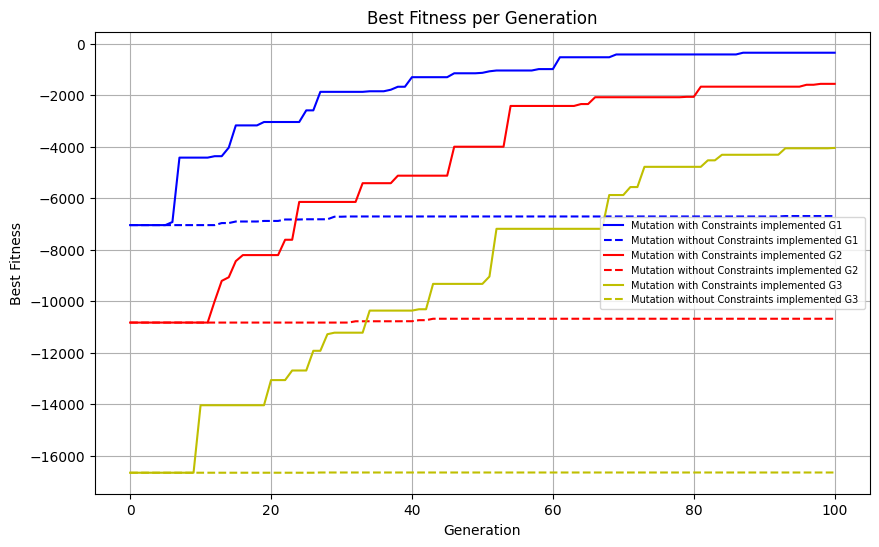

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(ga_instance_plain.best_solutions_fitness, linestyle='-', color='b', label='Mutation with Constraints implemented G1')
plt.plot(ga_instance_plain1.best_solutions_fitness,  linestyle='--', color='b', label='Mutation without Constraints implemented G1 ')
plt.plot(ga_instance_plain2.best_solutions_fitness, linestyle='-', color='r', label='Mutation with Constraints implemented G2')
plt.plot(ga_instance_plain2_1.best_solutions_fitness,  linestyle='--', color='r', label='Mutation without Constraints implemented G2')
plt.plot(ga_instance_plain3.best_solutions_fitness, linestyle='-', color='y', label='Mutation with Constraints implemented G3')
plt.plot(ga_instance_plain3_1.best_solutions_fitness,  linestyle='--', color='y', label='Mutation without Constraints implemented G3')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')
plt.legend(fontsize=7) 
plt.grid(True)

# Show the plot
plt.show()

In [170]:
num_genes = rows * cols * 2
mutation_wrapper1 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.4,0.1], 10*np.array([0.005,0.001]), [0.005,0.001])
mutation_wrapper4 = lambda offspring, ga_instance: swap_mutation2(offspring, ga_instance, [0.4,0.1], np.array([0.005,0.001]), [0.005,0.001])
mutation_wrapper2 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.25,0.25])
mutation_wrapper3 = lambda offspring, ga_instance: swap_mutation(offspring, ga_instance, [0.4,0.1])
dynamic_wrapper1 = lambda offspring, ga_instance: dynamic_mutation(offspring, ga_instance, 0.001e-07)
def dynamic_mutation2(offspring, ga_instance, threshold1 = 1, threshold2 = 0.001e-07):
    if ga_instance.generations_completed > 200:
        if ga_instance.best_solutions_fitness[-1]<0:
            if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-60] < threshold1:#0.00025
                return mutation_wrapper1(offspring, ga_instance)
        elif ga_instance.best_solutions_fitness[-1]>0:
            if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-60] < threshold2:
                return mutation_wrapper4(offspring, ga_instance)
    return mutation_wrapper3(offspring, ga_instance)

In [171]:
dynamic_wrapper2 = lambda offspring, ga_instance: dynamic_mutation2(offspring, ga_instance)
def on_generation2(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(ga_instance.best_solutions_fitness[-1])
    if ga_instance.generations_completed > 200:
        if ga_instance.best_solutions_fitness[-1]<0:
            if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-60] < 1:#0.00025
                print('laika')
            else:
                print("zibi")
        elif ga_instance.best_solutions_fitness[-1]>0:
            if ga_instance.best_solutions_fitness[-1] - ga_instance.best_solutions_fitness[-30] < 0.001e-07:
                print('laika')
            else:
                print("zibi")

In [70]:
import pygad
dynamic_wrapper1 = lambda offspring, ga_instance: dynamic_mutation(offspring, ga_instance, 0.5e-07)
initialtrial1 = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=8, ratio = 0.8)
ga_instancetrial1 = pygad.GA(num_generations=2500,
                       num_parents_mating=300,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper4 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initial,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial1.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solutiontrial1, solution_fitnesstrial1, solution_idxtrial1 = ga_instancetrial1.best_solution(ga_instancetrial1.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitnesstrial1}")


Generation: 1
1.0659534278773935e-07
Generation: 2
1.0659534278773935e-07
Generation: 3
1.0659534278773935e-07
Generation: 4
1.0659534278773935e-07
Generation: 5
1.0659534278773935e-07
Generation: 6
1.0659534278773935e-07
Generation: 7
1.0659534278773935e-07
Generation: 8
1.0659534278773935e-07
Generation: 9
1.0659534278773935e-07
Generation: 10
1.0659534278773935e-07
Generation: 11
1.0732933973436454e-07
Generation: 12
1.0732933973436454e-07
Generation: 13
1.0732933973436454e-07
Generation: 14
1.0744942101305175e-07
Generation: 15
1.0755438497140384e-07
Generation: 16
1.0755438497140384e-07
Generation: 17
1.0769687931889811e-07
Generation: 18
1.0803341142361362e-07
Generation: 19
1.0803341142361362e-07
Generation: 20
1.0803341142361362e-07
Generation: 21
1.0851995526140945e-07
Generation: 22
1.0851995526140945e-07
Generation: 23
1.0869828124284866e-07
Generation: 24
1.0991834283825378e-07
Generation: 25
1.10422052484424e-07
Generation: 26
1.10422052484424e-07
Generation: 27
1.10435878

In [52]:
initialtrial2 = generate_population(400, [0.55, 0.65, 0.75,0.85, 0.95], seed=8,  total_r = True, ratio = 0.8)

In [55]:
import pygad

        
ga_instancetrial2 = pygad.GA(num_generations=2500,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_wrapper2 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial2,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial2.run()

#ga_instance.plot_fitness(label=['Obj 1', 'Obj 2'])

solutiontrial2, solution_fitnesstrial2, solution_idxtrial2 = ga_instancetrial2.best_solution(ga_instancetrial2.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitnesstrial2}")


Generation: 1
1.2014133865865202e-07
Generation: 2
1.2014133865865202e-07
Generation: 3
1.2014133865865202e-07
Generation: 4
1.2014133865865202e-07
Generation: 5
1.2014133865865202e-07
Generation: 6
1.2014133865865202e-07
Generation: 7
1.2014133865865202e-07
Generation: 8
1.2014133865865202e-07
Generation: 9
1.2014133865865202e-07
Generation: 10
1.2026506878107392e-07
Generation: 11
1.2028043600414634e-07
Generation: 12
1.20285431900304e-07
Generation: 13
1.2041767190165449e-07
Generation: 14
1.2059543463203384e-07
Generation: 15
1.2059543463203384e-07
Generation: 16
1.213121536340895e-07
Generation: 17
1.213121536340895e-07
Generation: 18
1.213121536340895e-07
Generation: 19
1.213121536340895e-07
Generation: 20
1.2272750837473947e-07
Generation: 21
1.2272750837473947e-07
Generation: 22
1.2272750837473947e-07
Generation: 23
1.2272750837473947e-07
Generation: 24
1.2272750837473947e-07
Generation: 25
1.2272750837473947e-07
Generation: 26
1.2346520728711337e-07
Generation: 27
1.2346520728

In [92]:
seedl = []
seedfitl=[]
for seedi in range(1,50):
    initial_seed = generate_population(400, [0.55, 0.65, 0.75,0.85], seed=seedi)
    ga_instance_seed = pygad.GA(num_generations=1000,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initial_seed,
                       on_generation=on_generation,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

    ga_instance_seed.run()
    seedl.append(seedi)
    seedfitl.append(ga_instance_seed.best_solutions_fitness[-1])

Generation: 1
1.0237645824264627e-07
Generation: 2
1.0237645824264627e-07
Generation: 3
1.0237645824264627e-07
Generation: 4
1.0237645824264627e-07
Generation: 5
1.0237645824264627e-07
Generation: 6
1.0237645824264627e-07
Generation: 7
1.0237645824264627e-07
Generation: 8
1.0237645824264627e-07
Generation: 9
1.0268281144596357e-07
Generation: 10
1.0344631623041313e-07
Generation: 11
1.0393785981576502e-07
Generation: 12
1.0393785981576502e-07
Generation: 13
1.0393785981576502e-07
Generation: 14
1.0393785981576502e-07
Generation: 15
1.0393785981576502e-07
Generation: 16
1.0393785981576502e-07
Generation: 17
1.0440913212256153e-07
Generation: 18
1.0440913212256153e-07
Generation: 19
1.0555103300407869e-07
Generation: 20
1.0555103300407869e-07
Generation: 21
1.0555103300407869e-07
Generation: 22
1.0602373298132375e-07
Generation: 23
1.0602373298132375e-07
Generation: 24
1.0602373298132375e-07
Generation: 25
1.0648801562793849e-07
Generation: 26
1.0648801562793849e-07
Generation: 27
1.0648

In [256]:
kazibi = 16
initialtrial16= generate_population(400, [0.2,0.4,0.8,1], seed=16, total_r= 2)#, total_r= 1
#within constraint
fit = []
inConstraint = 0
for i in initialtrial16:
    fit.append(fitness_func(0,i,0))
    if fitness_func(0,i,0) >0:
        inConstraint +=1
print(np.median(fit))
print(max(fit))
print(inConstraint/len(fit))


-117995.5403284891
-12091.764138043105
0.0


In [272]:
ga_instancetrial16_adaptive_swap = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper3 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial16 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial16_adaptive_swap.run()

Generation: 1
-12091.764138043105
Generation: 2
-11779.420957122089
Generation: 3
-9621.037535859556
Generation: 4
-8602.75486574721
Generation: 5
-8602.75486574721
Generation: 6
-6407.914926815469
Generation: 7
-6407.914926815469
Generation: 8
-6407.914926815469
Generation: 9
-5437.58480842614
Generation: 10
-5437.58480842614
Generation: 11
-4858.180093151592
Generation: 12
-4858.180093151592
Generation: 13
-3579.6280316545976
Generation: 14
-3549.8652881499584
Generation: 15
-3148.552055585441
Generation: 16
-2947.2237469220727
Generation: 17
-2947.2237469220727
Generation: 18
-2947.2237469220727
Generation: 19
-2645.2131814850272
Generation: 20
-2645.2131814850272
Generation: 21
-2613.1651293526547
Generation: 22
-2577.2670187863005
Generation: 23
-2300.7246146652806
Generation: 24
-1813.2544947462404
Generation: 25
-1813.2544947462404
Generation: 26
-1129.2808350573837
Generation: 27
-1129.2808350573837
Generation: 28
-1129.280835057335
Generation: 29
-1129.280835057335
Generation:

In [273]:
ga_instancetrial16_constant_swap = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper2,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial16 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial16_constant_swap.run()

Generation: 1
-12091.764138043105
Generation: 2
-11688.753071295132
Generation: 3
-10986.235417256403
Generation: 4
-8544.855882462516
Generation: 5
-6668.666516027051
Generation: 6
-4791.229462550428
Generation: 7
-4791.229462550428
Generation: 8
-4791.229462550428
Generation: 9
-4638.546672071004
Generation: 10
-3877.841575064454
Generation: 11
-3405.685314914821
Generation: 12
-3405.685314914654
Generation: 13
-2521.3390348726157
Generation: 14
-2521.3390348726157
Generation: 15
-2521.3390348726157
Generation: 16
-2521.3390348726157
Generation: 17
-2521.3390348726157
Generation: 18
-2521.3390348726157
Generation: 19
-2512.2878707813666
Generation: 20
-1844.8000684007902
Generation: 21
-1844.8000684007902
Generation: 22
-1844.8000684007902
Generation: 23
-1844.8000684007902
Generation: 24
-1763.8482360557703
Generation: 25
-1763.8482360557703
Generation: 26
-1535.2299185735576
Generation: 27
-1065.913156921911
Generation: 28
-1065.913156921911
Generation: 29
-1065.9131569218262
Gener

In [261]:
ga_instancetrial16_dynamic = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial16 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial16_dynamic.run()

Generation: 1
-12091.764138043105
Generation: 2
-11779.420957122089
Generation: 3
-9621.037535859556
Generation: 4
-8602.75486574721
Generation: 5
-8602.75486574721
Generation: 6
-6407.914926815469
Generation: 7
-6407.914926815469
Generation: 8
-6407.914926815469
Generation: 9
-5437.58480842614
Generation: 10
-5437.58480842614
Generation: 11
-4858.180093151592
Generation: 12
-4858.180093151592
Generation: 13
-3579.6280316545976
Generation: 14
-3549.8652881499584
Generation: 15
-3148.552055585441
Generation: 16
-2947.2237469220727
Generation: 17
-2947.2237469220727
Generation: 18
-2947.2237469220727
Generation: 19
-2645.2131814850272
Generation: 20
-2645.2131814850272
Generation: 21
-2613.1651293526547
Generation: 22
-2577.2670187863005
Generation: 23
-2300.7246146652806
Generation: 24
-1813.2544947462404
Generation: 25
-1813.2544947462404
Generation: 26
-1129.2808350573837
Generation: 27
-1129.2808350573837
Generation: 28
-1129.280835057335
Generation: 29
-1129.280835057335
Generation:

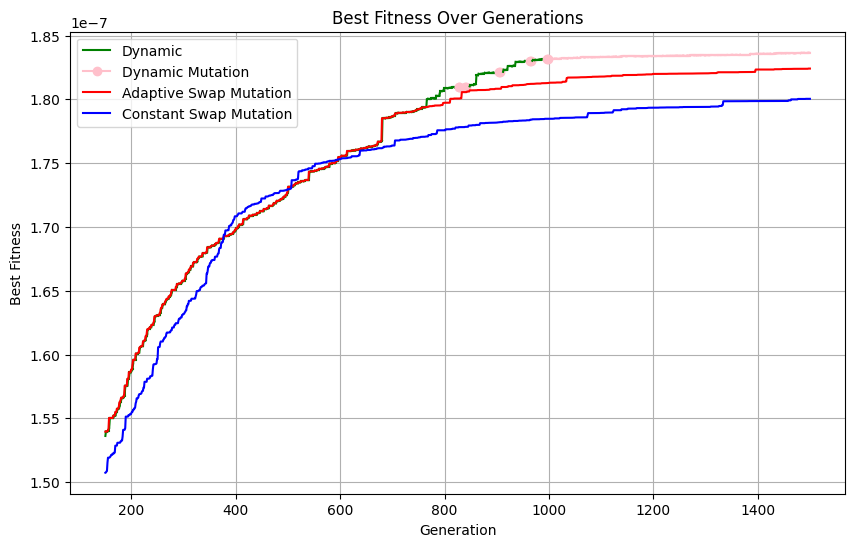

In [287]:
import matplotlib.pyplot as plt

# Read the data from the text file
file_path = 'output0_16.txt'  # Replace with your actual file path
with open(file_path, 'r') as file:
    lines = file.readlines()

generations = []
fitness_values = []
point_types = []
start_v = 150
with open(file_path, 'r') as file:
    lines = file.readlines()
    
    # Process the first 600 lines
    for i in range(0, 400, 2):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append("zibi")
    
    # Process lines after 600
    for i in range(400, len(lines), 3):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        point_type = lines[i + 2].strip()
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append(point_type)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the initial segment
plt.plot(generations[start_v:400//2], fitness_values[start_v:400//2], linestyle='-', color='green', label='Dynamic')

# Plot segments with special handling for "laika"
laika_label_added = False

for i in range(start_v, len(generations)):
    if point_types[i] == "zibi":
        plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='green')
    elif point_types[i] == "laika":
        if point_types[i-1] == "zibi":
            if not laika_label_added:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6, label='Dynamic Mutation')
                laika_label_added = True
            else:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6)
        else:
            plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink')

plt.plot(range(start_v,1501),ga_instancetrial16_adaptive_swap.best_solutions_fitness[start_v:], linestyle='-', color='r', label='Adaptive Swap Mutation')
plt.plot(range(start_v,1501),ga_instancetrial16_constant_swap.best_solutions_fitness[start_v:], linestyle='-', color='b', label='Constant Swap Mutation')
# Adding labels and title
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [294]:
initialtrial24= generate_population(400, [0.2,0.4,0.8,1], seed=24, total_r= 2)#, total_r= 1
#within constraint
fit = []
inConstraint = 0
for i in initialtrial24:
    fit.append(fitness_func(0,i,0))
    if fitness_func(0,i,0) >0:
        inConstraint +=1
print(np.median(fit))
print(max(fit))
print(inConstraint/len(fit))


-114097.99971485793
-15330.800324817894
0.0


In [298]:
ga_instancetrial24_adaptive_swap = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper3 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial24 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial24_adaptive_swap.run()

Generation: 1
-15330.800324817894
Generation: 2
-13412.484092989582
Generation: 3
-13412.484092989582
Generation: 4
-13412.484092989582
Generation: 5
-13412.484092989582
Generation: 6
-7243.926379228735
Generation: 7
-7243.926379228735
Generation: 8
-7243.926379228735
Generation: 9
-7019.086304361282
Generation: 10
-7019.086304361282
Generation: 11
-6875.59248910084
Generation: 12
-6601.716264519514
Generation: 13
-6601.716264519514
Generation: 14
-6309.755094030788
Generation: 15
-4486.898714192121
Generation: 16
-4486.898714192121
Generation: 17
-4141.487898212681
Generation: 18
-4141.487898212681
Generation: 19
-4141.487898212681
Generation: 20
-3754.983638674833
Generation: 21
-3754.983638674833
Generation: 22
-3599.418179128037
Generation: 23
-3337.8557515227994
Generation: 24
-3337.8557515227994
Generation: 25
-3150.3994268924907
Generation: 26
-2812.5092006024247
Generation: 27
-2191.011883932608
Generation: 28
-2191.011883932608
Generation: 29
-2191.011883932608
Generation: 30


In [297]:
ga_instancetrial24_constant_swap = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= mutation_wrapper2,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial24 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial24_constant_swap.run()

Generation: 1
-15330.800324817894
Generation: 2
-13412.484092989582
Generation: 3
-12560.457403828395
Generation: 4
-12560.457403828395
Generation: 5
-10687.23050761073
Generation: 6
-9294.179793591875
Generation: 7
-7232.659934307145
Generation: 8
-6695.320098259755
Generation: 9
-6695.320098259755
Generation: 10
-6695.320098259755
Generation: 11
-6695.320098259755
Generation: 12
-6285.4422338588665
Generation: 13
-5230.5787229502275
Generation: 14
-5230.5787229502275
Generation: 15
-5230.5787229502275
Generation: 16
-5230.57872295022
Generation: 17
-5230.57872295022
Generation: 18
-5230.5787229502075
Generation: 19
-3613.574028611171
Generation: 20
-3613.574028611171
Generation: 21
-3613.5740286109776
Generation: 22
-3389.3915230038947
Generation: 23
-3389.3915230038947
Generation: 24
-3226.6611496972832
Generation: 25
-2885.589554558658
Generation: 26
-2872.939588185667
Generation: 27
-2872.939588185667
Generation: 28
-2401.952084960836
Generation: 29
-1775.2851653910252
Generation:

In [296]:
ga_instancetrial24_dynamic = pygad.GA(num_generations=1500,
                       num_parents_mating=200,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial24 ,
                       on_generation=on_generation2,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=kazibi,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial24_dynamic.run()

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
-15330.800324817894
Generation: 2
-13412.484092989582
Generation: 3
-13412.484092989582
Generation: 4
-13412.484092989582
Generation: 5
-13412.484092989582
Generation: 6
-7243.926379228735
Generation: 7
-7243.926379228735
Generation: 8
-7243.926379228735
Generation: 9
-7019.086304361282
Generation: 10
-7019.086304361282
Generation: 11
-6875.59248910084
Generation: 12
-6601.716264519514
Generation: 13
-6601.716264519514
Generation: 14
-6309.755094030788
Generation: 15
-4486.898714192121
Generation: 16
-4486.898714192121
Generation: 17
-4141.487898212681
Generation: 18
-4141.487898212681
Generation: 19
-4141.487898212681
Generation: 20
-3754.983638674833
Generation: 21
-3754.983638674833
Generation: 22
-3599.418179128037
Generation: 23
-3337.8557515227994
Generation: 24
-3337.8557515227994
Generation: 25
-3150.3994268924907
Generation: 26
-2812.5092006024247
Generation: 27
-2191.011883932608
Generation: 28
-2191.011883932608
Generation: 29
-2191.011883932608
Generation: 30


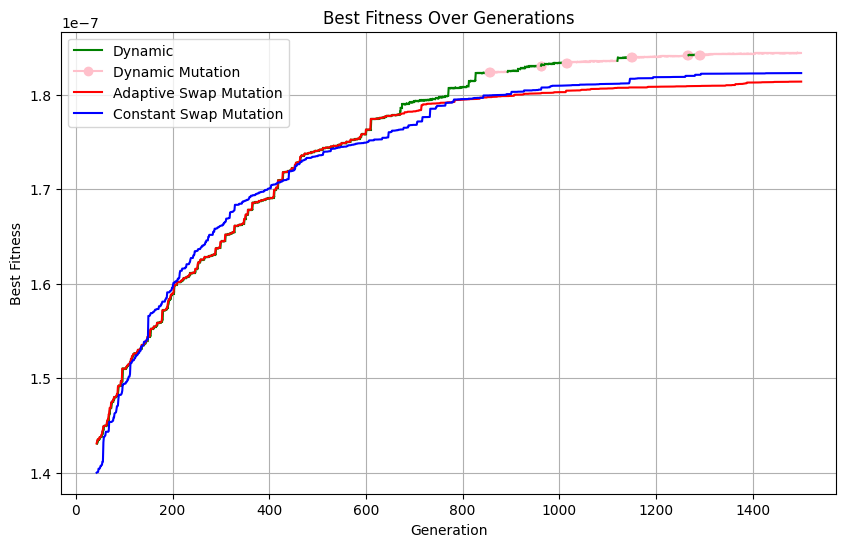

In [300]:
import matplotlib.pyplot as plt

# Read the data from the text file
file_path = 'output0_24.txt'  # Replace with your actual file path
with open(file_path, 'r') as file:
    lines = file.readlines()

generations = []
fitness_values = []
point_types = []
start_v = 43
with open(file_path, 'r') as file:
    lines = file.readlines()
    
    # Process the first 600 lines
    for i in range(0, 400, 2):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append("zibi")
    
    # Process lines after 600
    for i in range(400, len(lines), 3):
        generation = int(lines[i].strip().split(": ")[1])
        fitness = float(lines[i + 1].strip())
        point_type = lines[i + 2].strip()
        generations.append(generation)
        fitness_values.append(fitness)
        point_types.append(point_type)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot the initial segment
plt.plot(generations[start_v:400//2], fitness_values[start_v:400//2], linestyle='-', color='green', label='Dynamic')

# Plot segments with special handling for "laika"
laika_label_added = False

for i in range(start_v, len(generations)):
    if point_types[i] == "zibi":
        plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='green')
    elif point_types[i] == "laika":
        if point_types[i-1] == "zibi":
            if not laika_label_added:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6, label='Dynamic Mutation')
                laika_label_added = True
            else:
                plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink', marker='o', markersize=6)
        else:
            plt.plot(generations[i-1:i+1], fitness_values[i-1:i+1], linestyle='-', color='pink')

plt.plot(range(start_v,1501),ga_instancetrial24_adaptive_swap.best_solutions_fitness[start_v:], linestyle='-', color='r', label='Adaptive Swap Mutation')
plt.plot(range(start_v,1501),ga_instancetrial24_constant_swap.best_solutions_fitness[start_v:], linestyle='-', color='b', label='Constant Swap Mutation')
# Adding labels and title
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [304]:
initialtrial08= generate_population(400, [0.2,0.4,0.8,1], seed=32, total_r= 2)#, total_r= 1
#within constraint
fit = []
inConstraint = 0
for i in initialtrial08:
    fit.append(fitness_func(0,i,0))
    if fitness_func(0,i,0) >0:
        inConstraint +=1
print(np.median(fit))
print(max(fit))
print(inConstraint/len(fit))


-114972.4667326645
-12159.97274360405
0.0


In [96]:

ga_instancetrial3 = pygad.GA(num_generations=2500,
                       num_parents_mating=100,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       gene_space=gene_space,
                       #stop_criteria=["reach_100"],
                       mutation_type= dynamic_wrapper1 ,
                       #mutation_probability = [0.03, 0.01],
                       keep_elitism=5,
                       initial_population= initialtrial3,
                       on_generation=on_generation,
                       #mutation_type = 'swap'
                       #crossover_probability=0.01,
                       #crossover_type=crossover,
                       #parent_selection_type='tournament'
                       #crossover_type='two_points',
                       random_seed=1,
                       #parent_selection_type="sus"
                       #initial_population= ga_instance1.population,
                       )

ga_instancetrial3.run()
solutiontrial3, solution_fitnesstrial3, solution_idxtrial3 = ga_instancetrial3.best_solution(ga_instancetrial3.last_generation_fitness)
#print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitnesstrial3}")

c:\Users\Searc\OneDrive\Math\College\M4R\M4RCode\m4renv\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation: 1
1.0434459623286859e-07
Generation: 2
1.0434459623286859e-07
Generation: 3
1.0434459623286859e-07
Generation: 4
1.0434459623286859e-07
Generation: 5
1.0434459623286859e-07
Generation: 6
1.0434459623286859e-07
Generation: 7
1.0434459623286859e-07
Generation: 8
1.0434459623286859e-07
Generation: 9
1.0434459623286859e-07
Generation: 10
1.0434459623286859e-07
Generation: 11
1.0434459623286859e-07
Generation: 12
1.0460859475655294e-07
Generation: 13
1.0460859475655294e-07
Generation: 14
1.0528825063355882e-07
Generation: 15
1.057786966211211e-07
Generation: 16
1.057786966211211e-07
Generation: 17
1.057786966211211e-07
Generation: 18
1.057786966211211e-07
Generation: 19
1.0584321230374396e-07
Generation: 20
1.0584321230374396e-07
Generation: 21
1.0630909365105077e-07
Generation: 22
1.0630909365105077e-07
Generation: 23
1.0630909365105077e-07
Generation: 24
1.0630909365105077e-07
Generation: 25
1.0630909365105077e-07
Generation: 26
1.0630909365105077e-07
Generation: 27
1.06309093